In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
%matplotlib notebook

#### The next cell must be converted back to code if the dataframe needs to be rebuilt from csv

In [42]:
# Start here
df=pd.read_pickle('co_police_arrests.pkl')

In [46]:
# Check which columns have null values
df.isnull().sum()

stop_date                  2
county_name                0
police_department       4008
driver_gender           2299
driver_race                0
violation             138358
search_conducted           0
search_type          1422065
stop_outcome          157710
is_arrested                0
dtype: int64

In [47]:
# Get rid of the two null date cases and create new year column
df=df.dropna(subset=['stop_date'])
df.loc[:,'year']=df.stop_date.apply(lambda y: int(y[:4]))

In [137]:
# Let's look at DUIs
print df.violation.unique().shape
print "DUI's: {}".format(df[df.violation == 'DUI'].violation.value_counts().get(0))
print "DUI rank is {}".format((df.violation.value_counts() >= 1633).sum())
print "Violations of type 'Other' in top 50 violations: {}".format((df.violation.value_counts()[:50].index.str.find("Other") != -1).sum())

(1640,)
DUI's: 1633
DUI rank is 47
Violations of type 'Other' in top 50 violations: 9


In [175]:
# Drop "other" violations and make a simplified dataframe with the top 40 violations
vdf = df.drop(df[df.violation.str.find("Other") != -1].index)
vdf = vdf[vdf.violation.isin(vdf.violation.value_counts()[:40].index.tolist())]
vdf.violation.value_counts()[:5]

Speeding               481037
Safe movement          178667
Lights                  90962
Registration/plates     79719
Truck                   28828
Name: violation, dtype: int64

In [139]:
# Counties around Denver: Jefferson, Douglas, Adams, Arapahoe...
# ... arguably Boulder and Clear Creek
countyList = ['Denver County','Douglas County', 'Adams County', 'Arapahoe County','Jefferson County']
denDF = vdf[vdf.county_name.isin(countyList)]
denDF.county_name.value_counts()

Jefferson County    80885
Adams County        64393
Arapahoe County     42012
Douglas County      37367
Denver County         684
Name: county_name, dtype: int64

In [145]:
# Let's just look at speeding, safe movement, lights, and registration/plates
# for now and drop the 'other' race category

denDF = denDF[denDF.driver_race != 'Other']
denDF = denDF[denDF.violation.isin(['Speeding','Safe movement','Lights','Registration/plates'])]

<IPython.core.display.Javascript object>


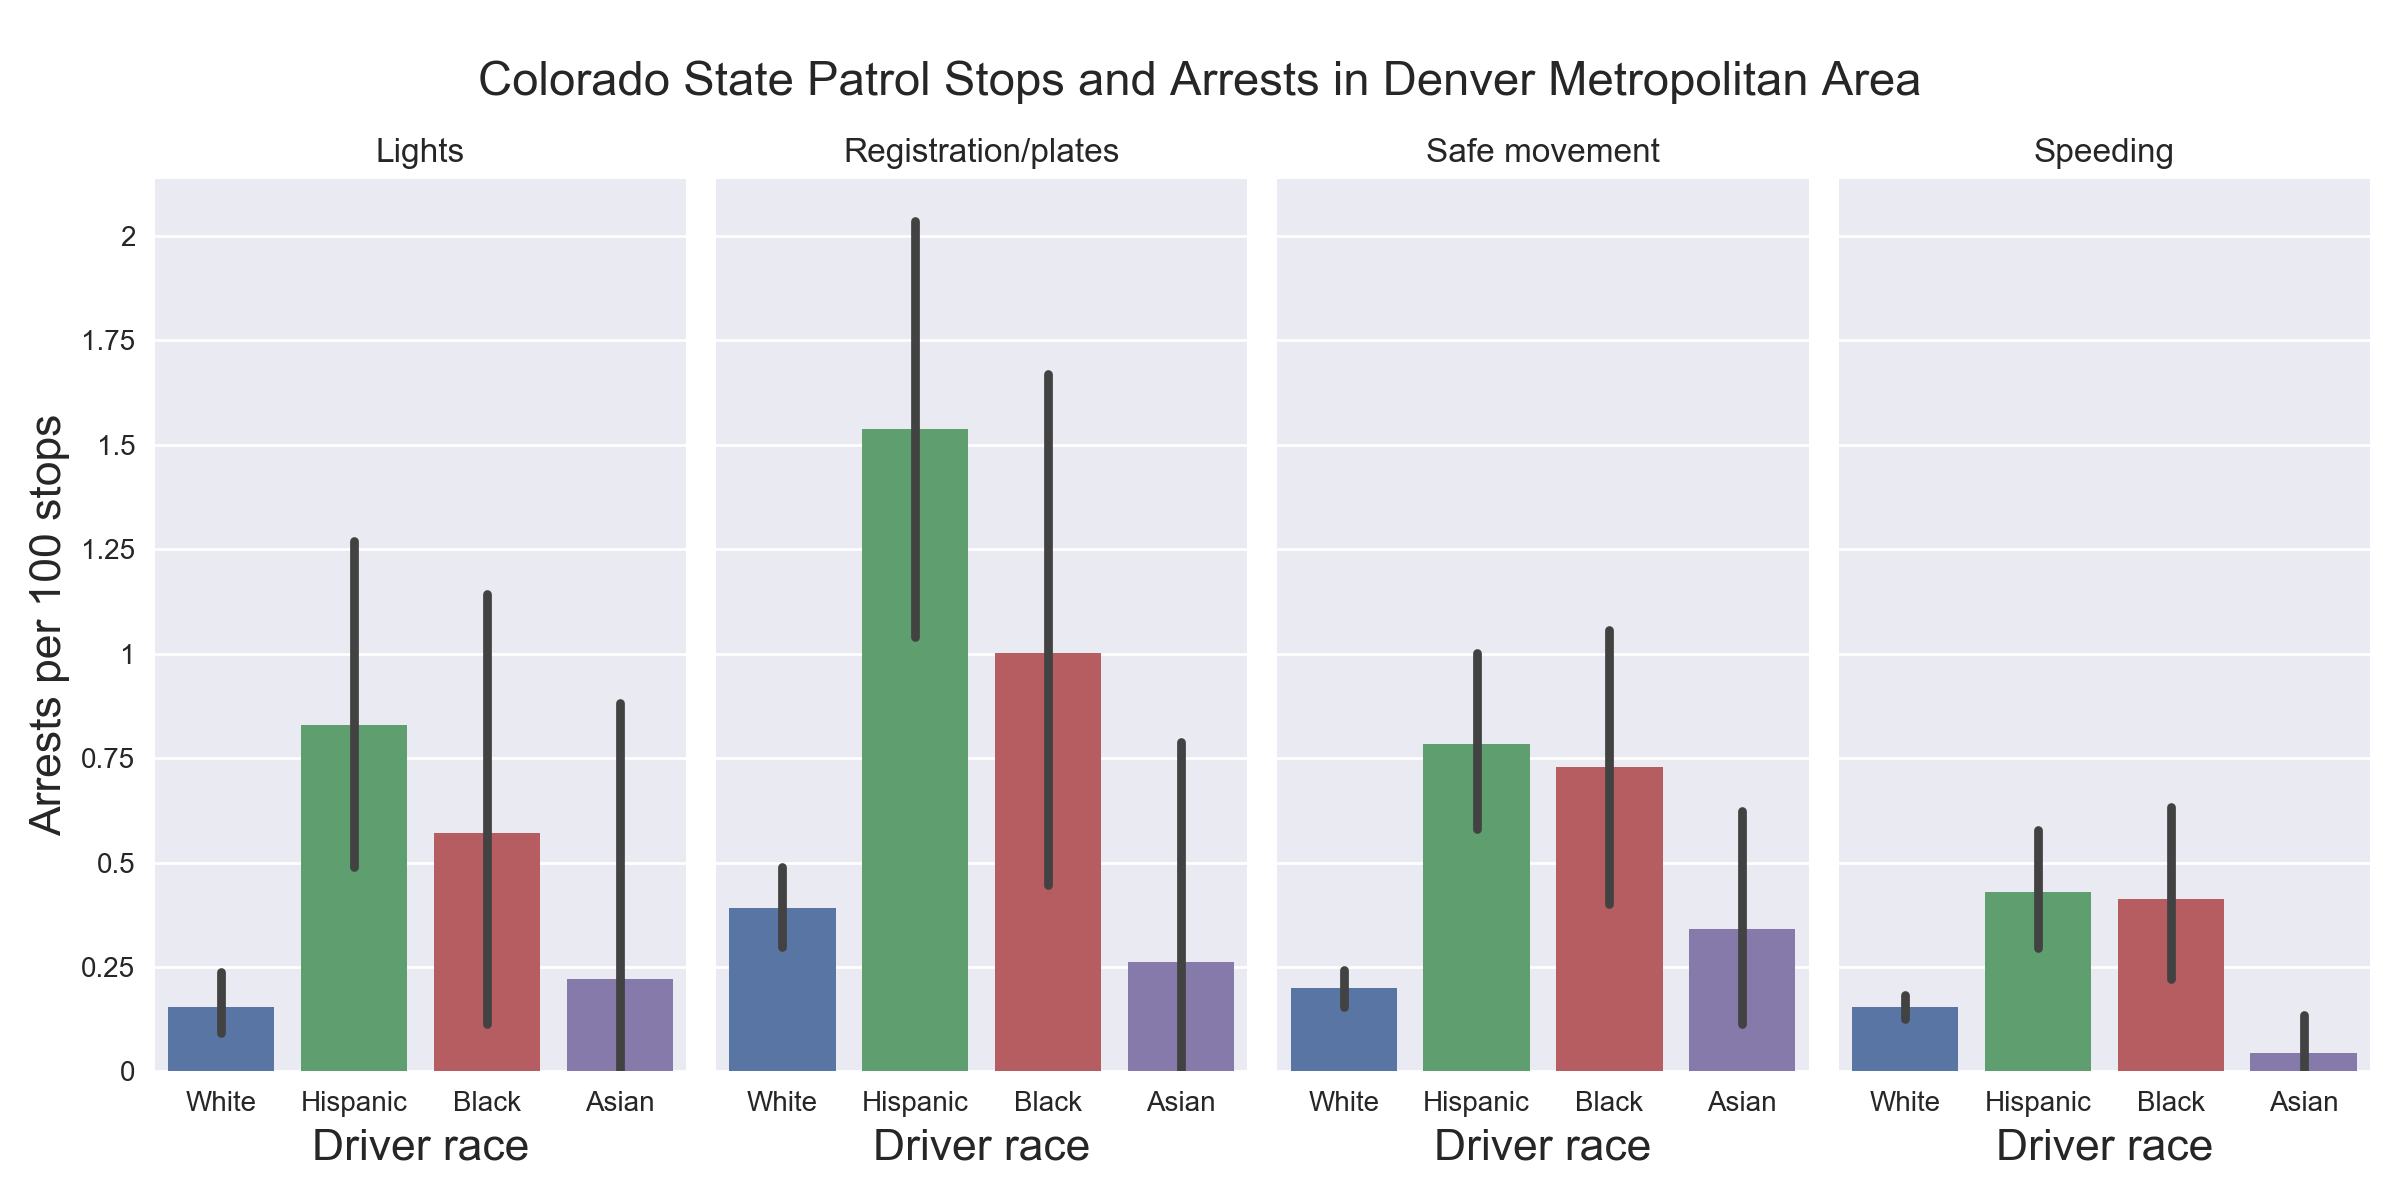

In [171]:
order=['White','Hispanic','Black','Asian']
per100 = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x*100))
fig,axs = plt.subplots(nrows=1,ncols=4,sharey=True,figsize=(12,6))
for ax,(violation,vgroup) in zip(axs,denDF.groupby('violation')):
    sns.barplot('driver_race','is_arrested',data=vgroup,ax=ax,order=order,ci=95)
    ax.set_ylabel('')
    ax.set_xlabel('Driver race',fontsize=16)
    ax.set_title(str(violation))
axs[0].yaxis.set_major_formatter(per100)
axs[0].set_ylabel("Arrests per 100 stops",fontsize=16)
fig.tight_layout(rect=(0,0,1,0.91))
fig.suptitle("Colorado State Patrol Stops and Arrests in Denver Metropolitan Area",fontsize=17,y=0.95)

<IPython.core.display.Javascript object>


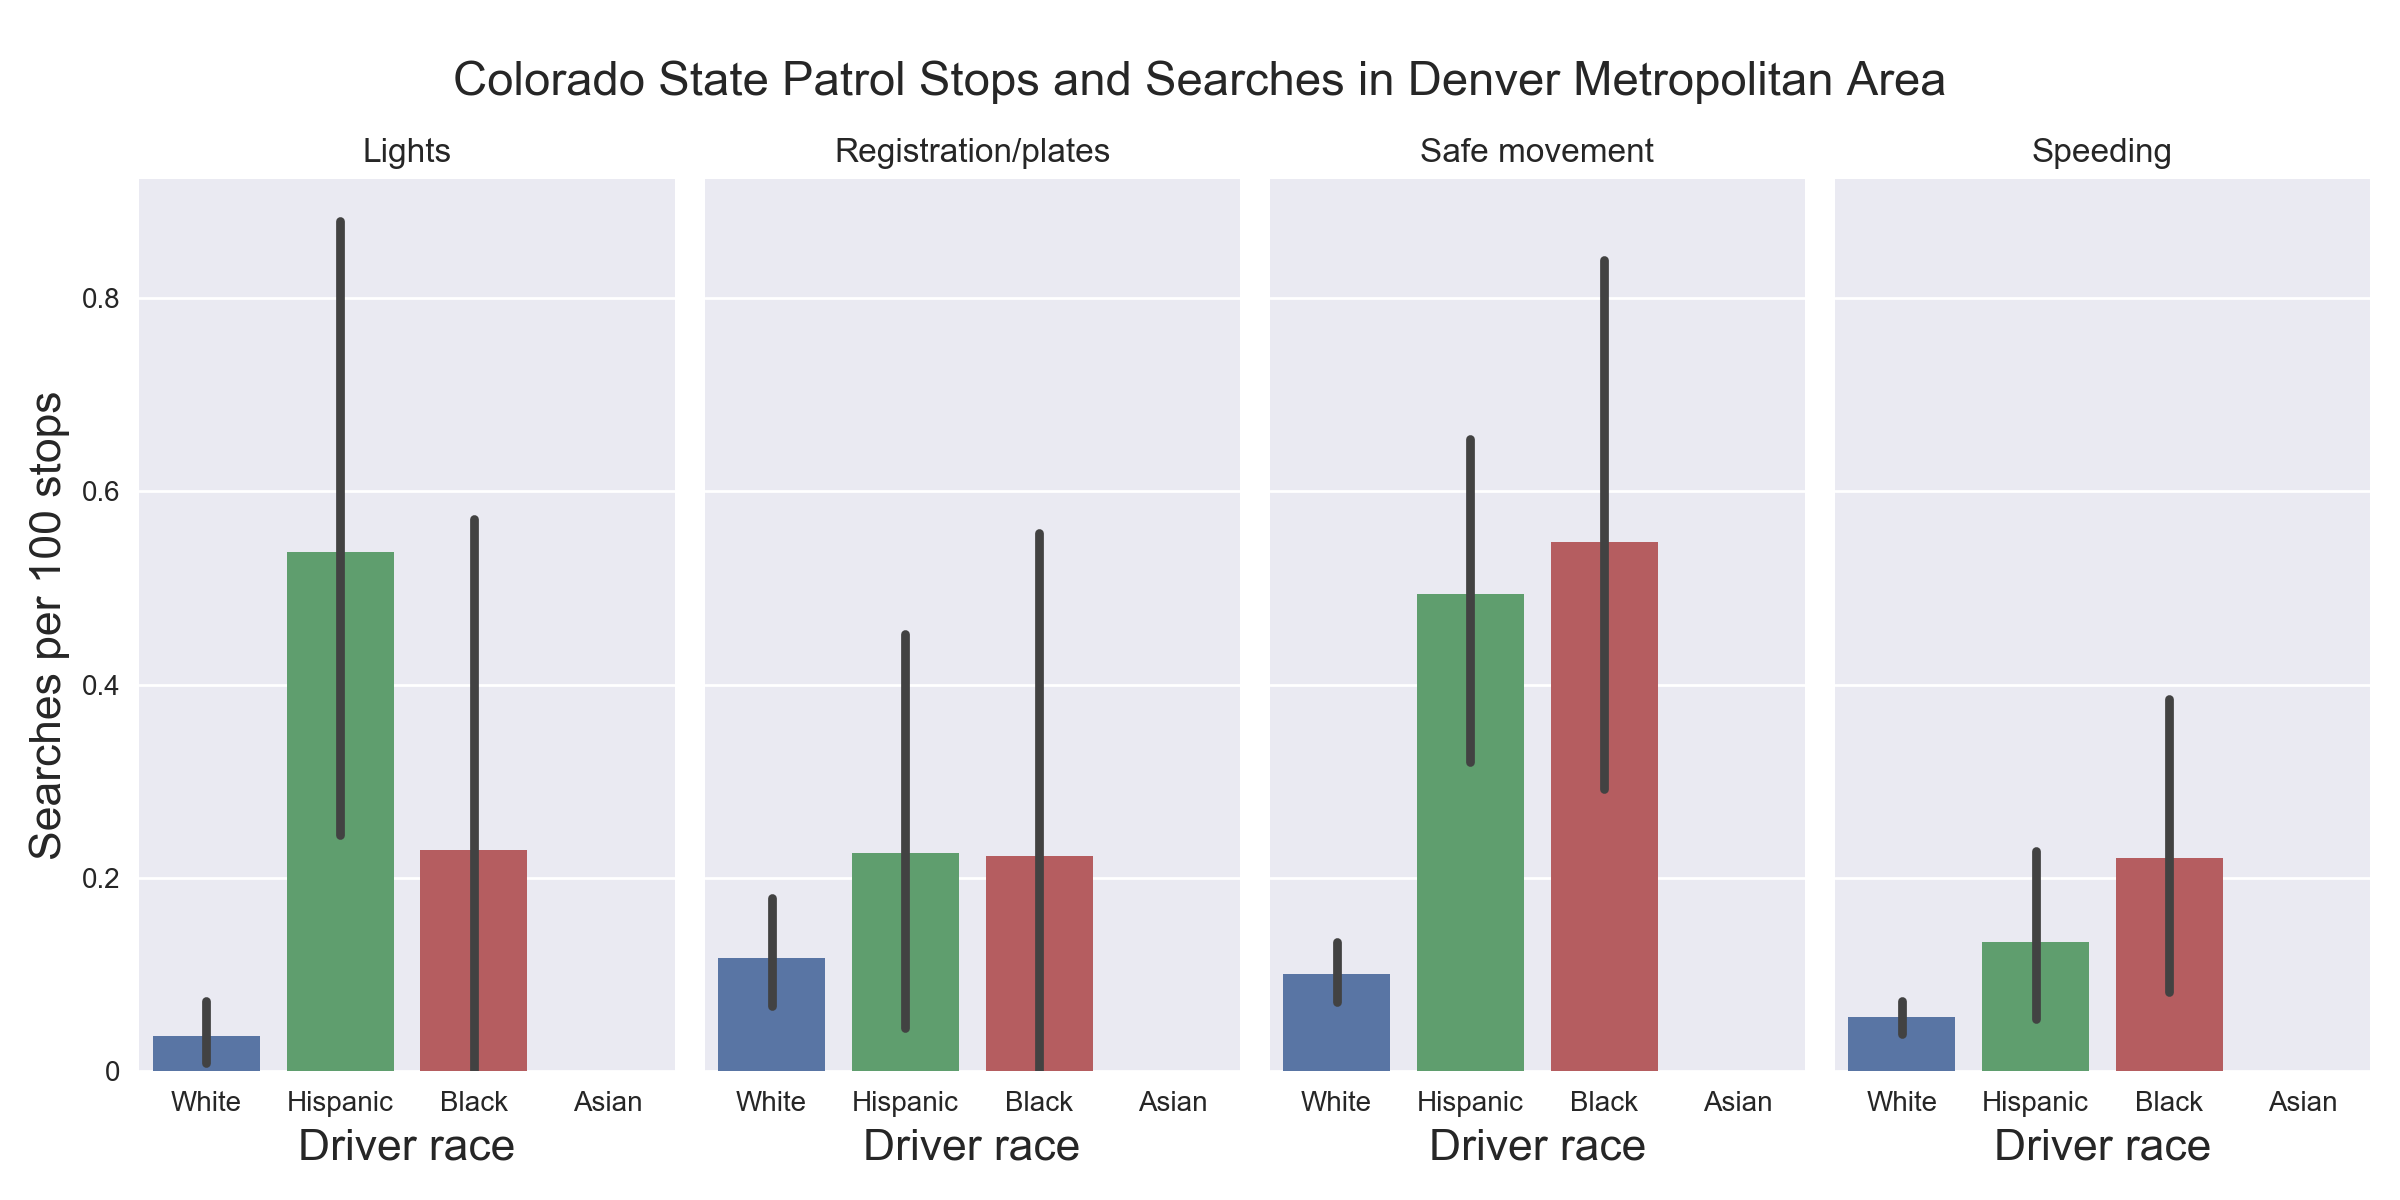

In [172]:
fig,axs = plt.subplots(nrows=1,ncols=4,sharey=True,figsize=(12,6))
for ax,(violation,vgroup) in zip(axs,denDF.groupby('violation')):
    sns.barplot('driver_race','search_conducted',data=vgroup,ax=ax,order=order,ci=95)
    ax.set_ylabel('')
    ax.set_xlabel('Driver race',fontsize=16)
    ax.set_title(str(violation))
axs[0].yaxis.set_major_formatter(per100)
axs[0].set_ylabel("Searches per 100 stops",fontsize=16)
fig.tight_layout(rect=(0,0,1,0.91))
fig.suptitle("Colorado State Patrol Stops and Searches in Denver Metropolitan Area",fontsize=17,y=0.95)

In [173]:
# Weirdly, there were no searches of asian drivers, and it appears that arrests are more common than searches
pd.crosstab(denDF.driver_race,denDF.search_conducted)

search_conducted,False,True
driver_race,,
Asian,4815,0
Black,8118,27
Hispanic,18522,60
White,136991,103


In [174]:
pd.crosstab(denDF.driver_race,denDF.is_arrested)

is_arrested,False,True
driver_race,,
Asian,4806,9
Black,8096,49
Hispanic,18445,137
White,136826,268
